In [17]:
### Roleta ####
import random


### Roleta ###

# Rodar a roleta
def roulette_run (rounds, roulette):
    if roulette == []:
        return []
    selected = []
    #print(rounds, roulette)
    while len(selected) < rounds:
        r = random.uniform(0,1)
        for state in roulette:
            if r <= state[0]:
                selected.append(state[1])
                break
    return selected

def roulette_construction(states):
    aux_states = []
    roulette = []
    #Valores de todos estados
    values = [s.Value() for s in states]
    total_values = sum(values)
    total_values = total_values if total_values != 0 else 1

    #Inverte a porcentagem, dando prioridade aos menores e soma o total
    total_invert = sum(1-values/total_values)

    for state in states:
        value = state.Value()
        if total_invert != 0:
            ratio = (1-value/total_values)/total_invert
        else:
            ratio = 1
        aux_states.append((ratio,state))

    acc_value = 0
    for state in aux_states:
        acc_value = acc_value + state[0]
        s = (acc_value,state[1])
        roulette.append(s)
    return roulette

In [18]:
### IState ###
class IState:
    def Value(self):
        pass
    def NextState(self):# -> IState:
        pass
    def Equal(self, other):
        pass
    def Compare(self, other):
        pass

In [19]:
### Cluster ###
import numpy as np
import random
#from IState import IState
from sklearn.utils import shuffle

class Cluster(IState):
    def __init__(self, X, k, grupos = None,centroides = None):
        self.X = X
        self.grupos = grupos
        self.centroides = centroides
        self.k = k
        self.sse = 0
        if grupos is not None:
            self.GerarCentroide()
        else:
            self.GerarGrupos()

    def Shuffle(self):
        self.X, self.grupos = shuffle(self.X, self.grupos)
        self.GerarCentroide()

    def set_k(self,k):
        self.k = k

    def get_grupos(self):
        return np.arange(0,self.k)
    
    def set_grupos(self, grupos):
        self.grupos =  grupos
        self.GerarCentroide()
    
    def GerarGrupos(self):
        length = len(self.X)
        repeat = int(length/self.k) + 1
        #self.grupos = np.random.randint(0,self.k,len(self.X))
        self.grupos =  np.array([_ for _ in range(self.k)]*repeat)[:length]
        #print(self.grupos)
        
        self.GerarCentroide()

    def GerarCentroide(self):
        self.centroides = np.array([sum(self.X[self.grupos == g])/len(self.X[self.grupos == g]) for g in self.get_grupos()])
        self.SSE()

    
    ####### Distancia Euclidia ##########
    def SomaDistanciaEuclidia(self, X, centroide):
        return sum([np.linalg.norm(x-centroide) for x in X])

    def SSE(self):
        self.sse = sum([self.SomaDistanciaEuclidia(self.X[self.grupos == g],self.centroides[g]) for g in self.get_grupos()])
        return self.sse

    def Show(self):
        print('Grupos:', self.grupos)
        print('Centroides:', self.centroides)
        print('Pontos:', self.X)

    ##### IState ######
    def Value(self):
        return self.sse

    def NextState(self):
        return self.Mutation()

    #Compara se os grupos de dois clusters são iguais
    def Equal(self, other):
        return np.array_equal(self.grupos, other.grupos)

    #IMutable methods
    def Crossover(self,other):
        r = random.randint(0, len(self.grupos) - 1)
        son = np.concatenate((self.grupos[:r], other.grupos[r:]), axis=0)
        daug = np.concatenate((other.grupos[:r], self.grupos[r:]), axis=0)


        #Se o número de grupos for menor que K cancela esse cruzamento
        if(len(np.unique(son)) < self.k):
            son = self.grupos
        if(len(np.unique(daug)) < self.k):
            daug = other.grupos
        son, daug = Cluster(X = self.X, k = self.k, grupos=son), Cluster(X = self.X, k = self.k, grupos=daug)



        return son, daug
    
    def get_number_states(self):
        return self.k
    
    def ChangeState(self, index, value):
        new_grupos = self.grupos.copy()

        old_value = new_grupos[index]
        new_value = old_value + value

        if(new_value < 0):
            new_grupos[index] = self.k-1
        elif new_value >= self.k:
            new_grupos[index] =  0
        else:
            new_grupos[index] = new_value
        
        #Verifica se continua com K grupos
        if len(np.unique(new_grupos)) < self.k:
            new_grupos[index] = old_value #Volta so estado anterior, mantendo K grupos

        return Cluster(
            X = self.X, 
            k = self.k, 
            grupos = new_grupos
        )


    def Mutation(self):
        new_grupos = self.grupos.copy()

        if(self.k > 1):#Se tiver só um grupo, não precisa fazer mutação
            index = random.randint(0, len(new_grupos)-1)
            while new_grupos[index] == self.grupos[index] or len(np.unique(new_grupos)) < self.k:
                index = random.randint(0, len(new_grupos)-1)
                new_grupos[index] = random.randint(0, self.k - 1)
        
        return Cluster(
            X = self.X, 
            k = self.k, 
            grupos = new_grupos
        ) 


In [20]:
## Algoritimo Genético ##
import random
import time
import math
#from Roleta import roulette_construction, roulette_run
#from Cluster import Cluster

class IMutable:
    def Crossover(self, other):
        pass
    def Mutation(self):
        pass

class Genetic:
    def __init__(self,k ,pop_size = 10, cross_ratio = 0.75, mut_ratio = 0.2, max_time = 1, elite_pct = 0.05):
        self.k = k
        self.pop_size = pop_size 
        self.cross_ratio = cross_ratio
        self.mut_ratio = mut_ratio
        self.max_time = max_time
        self.elite_pct = elite_pct
        self.solution : IMutable = None

    def fit(self, x_train):
        self.state = Cluster(X = x_train, k = self.k)

        self.Run()

        self.cluster_centers_ = self.solution.centroides

    def Run(self):
        start = time.process_time()
        opt_state = self.state
        opt_value = opt_state.Value()
        population = self.initial_population(self.pop_size)
        conv = self.convergent(population)
        end = 0
        cont = 0
        while not conv and end-start <= self.max_time:
            cont+=1
            
            #val_pop = evaluate_population (pop, items)
            new_pop = self.elitism (population)
            best = new_pop[0]
            val_best = best.Value()

            if (val_best < opt_value):
                opt_state = best
                opt_value = val_best

            selected = self.selection(population, self.pop_size - len(new_pop)) 
            crossed = self.crossover_step(selected)
            mutated = self.mutation_step(crossed)
            population = new_pop + mutated
            conv = self.convergent(population)

            end = time.process_time()
        self.solution = opt_state
        #print(cont, end-start,conv)
        return self.solution

    def convergent(self,population):
        conv = False
        if population != []:
            base = population[0]
            i = 0
            while i < len(population):
                if not base.Equal(population[i]):
                    return False
                i += 1
            return True

    def initial_population(self, n):
        pop = []
        count = 0
        while count < n:
            individual = self.state.NextState()
            pop = pop + [individual]
            count += 1
        return pop

    def elitism (self,population):
        n = math.floor(self.elite_pct*len(population))
        if n < 1:
            n = 1
        elite = sorted (population, key = lambda x: x.Value())[:n]
        return elite

    def selection(self, population,n):
        aux_population = roulette_construction(population)
        new_population = roulette_run(n, aux_population)
        return new_population


    # Etapa de Recombinação
    def crossover_step (self, population):
        new_pop = []
        
        for _ in range (round(len(population)/2)):
            rand = random.uniform(0, 1)
            fst_ind = random.randint(0, len(population) - 1)
            scd_ind = random.randint(0, len(population) - 1)
            parent1 = population[fst_ind] 
            parent2 = population[scd_ind]

            if rand <= self.cross_ratio:
                offspring1, offspring2 = parent1.Crossover(parent2)            
            else:
                offspring1, offspring2 = parent1, parent2
                    
            new_pop = new_pop + [offspring1, offspring2]
            
        return new_pop

    # Etapa de Mutação
    def mutation_step (self, population):
        ind = 0
        for individual in population:
            rand = random.uniform(0, 1)
            if rand <= self.mut_ratio:
                mutated = individual.Mutation()
                population[ind] = mutated           
            ind+=1
            
        return population 

In [21]:
## Algorimo KCentroides ###

import numpy as np
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y
from sklearn.cluster import KMeans
#from Genetic import Genetic

class KCentroides(BaseEstimator):
    def __init__(self,algoritimo = 'KMeans', k=None):
        super().__init__()
        self.k = k
        self.algoritimo = algoritimo
    
    def fit(self,x_train,y_train):
        x_train,y_train = check_X_y(x_train,y_train)

        alg = KMeans(n_clusters = self.k) if self.algoritimo == 'KMeans' else Genetic(k= self.k)
        #print(self.k)

        self.__self_pred = []
        for classe in np.unique(y_train):
            alg.fit(x_train[y_train == classe])
            for centroide in  alg.cluster_centers_:
                self.__self_pred.append((centroide, classe))
        return self.__self_pred

    def predict(self,x_test):
        
        distancia = lambda a,b : np.linalg.norm(a-b)


        #Varre todos pontos e retorna a classe do centroide mais próximo a cada um
        return np.array([
            #Retorna a classe do centróide que está mais próximo do ponto
            min(
                [(distancia(ponto,centroide),classe) for (centroide,classe) in self.__self_pred], #Distancia do ponto e cada centroide calculado
                key = lambda dist_class: dist_class[0]#Compara pela distância
                )[1]# Retorna a classe
                    for ponto in x_test #Varre por todos pontos da matriz x_test
        ])


In [22]:
## Algoritimo OneR Probabilistico ##

import numpy as np
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd

class OneR(BaseEstimator):
    
    def fit(self,x_train,y_train):
        x_train,y_train = check_X_y(x_train,y_train)

        self.n_classes = len(np.unique(y_train))
        
        #Discretiza
        est = KBinsDiscretizer(n_bins=2*self.n_classes, encode='ordinal', strategy='kmeans').fit(x_train)
        X_bin = est.transform(x_train)



        n_caracteristica = x_train.shape[1]
        
        self.classes = np.unique(y_train)

        #Pra cada caracteristica gera um matriz da associação [[caracteristica,valor, classe] ]
        datas = [[[caracteristica,valor, classe] for (valor, classe) in zip(X_bin[:,caracteristica],y_train)] for caracteristica in range(n_caracteristica)]

        #Lista de dataframes pivoteados
        dfs = []
        #Lista das dos maiores valores das caracteristicas por classes
        lst = []
        for data in datas:
            data = np.array(data)
            
            #Pivotei as matrizes usando pandas
            df = pd.DataFrame(data=data,columns=['caracteristica','valor', 'classe'])
            pivot = pd.pivot_table (df, values = "caracteristica", 
                                    index = "valor", columns = "classe", 
                                    aggfunc = "count")
            #Zera os valores nulos
            pivot = pivot.fillna(0)

            
            #Adiciona as listas
            lst.append((data[0][0],pivot.max().values))
            dfs.append(pivot)

        
        #Caracteristica que mais se destaca
        self.caracteristica = int(max(lst, key = lambda x: sum(x[1]))[0])


        #Tabela de contigencia da caracteristica que mais se destaca
        self.matriz = dfs[self.caracteristica]

    def predict(self,x_test):
        #Discretiza
        est = KBinsDiscretizer(n_bins=2*self.n_classes, encode='ordinal', strategy='kmeans').fit(x_test)
        X_bin = est.transform(x_test)


        result = []
        
        
        for X in X_bin:
            #As vezes esse valor caricteristica não foi usado no treino, mas existe no teste. Nesse caso a probabilidade é igual pra todas classes
            if X[self.caracteristica] in self.matriz.index:
                array = self.matriz.loc[X[self.caracteristica]]
                result.append(np.random.choice(self.classes,1,p=array/sum(array))[0])
            else:
                result.append(np.random.choice(self.classes,1)[0])
        return result

-----------------------------------------------
---                  iris                ---
-----------------------------------------------
--------------------Médias---------------------
                    Método     Média  Desvio Padrão  Limite Inferior  \
0                    ZeroR  0.333333   1.110223e-16         0.333333   
1                Aleatório  0.344444   1.420311e-01         0.293620   
2  Aleatório Estratificado  0.328889   1.519584e-01         0.274512   
3      OneR Probabilístico  0.753333   1.531400e-01         0.698534   
4    Naive Bayes Gaussiano  0.951111   5.144816e-02         0.932701   
5                      Knn  0.946667   6.061414e-02         0.924977   
6                  DistKnn  0.948889   6.130273e-02         0.926952   
7        Árvore de Decisão  0.953333   4.602737e-02         0.936863   
8     Florestas de Árvores  0.951111   4.532462e-02         0.934892   

   Limite Superior  
0         0.333333  
1         0.395269  
2         0.383266  
3     

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


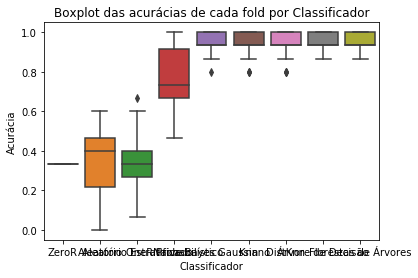

-----------------------------------------------
---                  digits                ---
-----------------------------------------------
--------------------Médias---------------------
                    Método     Média  Desvio Padrão  Limite Inferior  \
0                    ZeroR  0.101285       0.002436         0.100413   
1                Aleatório  0.099622       0.022088         0.091718   
2  Aleatório Estratificado  0.097581       0.021434         0.089911   
3      OneR Probabilístico  0.096468       0.025302         0.087414   
4    Naive Bayes Gaussiano  0.784305       0.030236         0.773485   
5                      Knn  0.974223       0.011955         0.969945   
6                  DistKnn  0.975889       0.011516         0.971768   
7        Árvore de Decisão  0.855687       0.020908         0.848205   
8     Florestas de Árvores  0.974767       0.010747         0.970921   

   Limite Superior  
0         0.102157  
1         0.107526  
2         0.105251  
3   

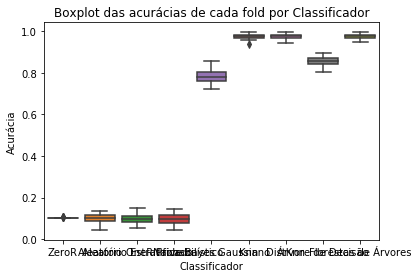

-----------------------------------------------
---                  wine                ---
-----------------------------------------------
--------------------Médias---------------------
                    Método     Média  Desvio Padrão  Limite Inferior  \
0                    ZeroR  0.399346       0.024707         0.390505   
1                Aleatório  0.335294       0.111554         0.295376   
2  Aleatório Estratificado  0.361220       0.101821         0.324784   
3      OneR Probabilístico  0.575054       0.102218         0.538477   
4    Naive Bayes Gaussiano  0.973420       0.048205         0.956171   
5                      Knn  0.960458       0.053188         0.941425   
6                  DistKnn  0.958497       0.054918         0.938845   
7        Árvore de Decisão  0.897059       0.066626         0.873218   
8     Florestas de Árvores  0.973856       0.040060         0.959521   

   Limite Superior  
0         0.408188  
1         0.375213  
2         0.397656  
3     

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


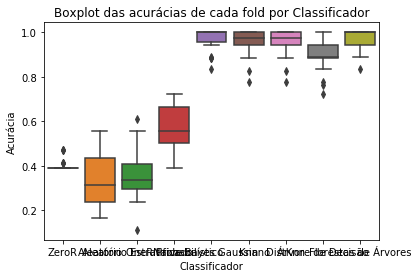

-----------------------------------------------
---                  breast_cancer                ---
-----------------------------------------------
--------------------Médias---------------------
                    Método     Média  Desvio Padrão  Limite Inferior  \
0                    ZeroR  0.627412       0.006966         0.624920   
1                Aleatório  0.502120       0.072633         0.476129   
2  Aleatório Estratificado  0.526003       0.059955         0.504548   
3      OneR Probabilístico  0.609712       0.101263         0.573476   
4    Naive Bayes Gaussiano  0.933782       0.026349         0.924354   
5                      Knn  0.965455       0.024192         0.956798   
6                  DistKnn  0.966040       0.023527         0.957621   
7        Árvore de Decisão  0.925606       0.031604         0.914297   
8     Florestas de Árvores  0.964860       0.024387         0.956134   

   Limite Superior  
0         0.629905  
1         0.528111  
2         0.547457

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


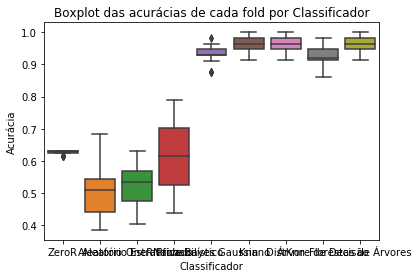

In [37]:
######################################
### Classificação dos Algoritimos ####
######################################

import numpy as np
import pandas as pd
from scipy import stats
from sklearn import datasets
from sklearn.model_selection import cross_val_predict 
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from scipy.stats import ttest_rel, wilcoxon
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
#from KCentroides import KCentroides
#from OneR import OneR


nomes = [
            'ZeroR', 
            'Aleatório', 
            'Aleatório Estratificado', 
            'OneR Probabilístico', 
            'Naive Bayes Gaussiano', 

            'KmeansCentroides',
            'KGACentroides',
            'Knn',
            'DistKnn',
            'Árvore de Decisão',
            'Florestas de Árvores'
        ]

#iris, digits, wine e breast cancer
datas = [datasets.load_iris(), datasets.load_digits(), datasets.load_wine(), datasets.load_breast_cancer()]
data_names = ['iris', 'digits', 'wine', 'breast_cancer']

param_kmeans = {'estimator__k': [1, 3, 5, 7]}
param_kga = {'estimator__k': [1, 3, 5, 7]}
param_knn = {'estimator__n_neighbors': [1, 3, 5, 7]}
param_DistKnn = {'estimator__n_neighbors': [1, 3, 5, 7]}
param_Arvore = {'estimator__max_depth': [None,3, 5, 10]}
param_Floresta = {'estimator__n_estimators': [10, 20, 50, 100]}

scalar = StandardScaler()

def get_pipeline(classificador):
    return Pipeline([('transformer', scalar), ('estimator', classificador)])

def get_gridSearchCV(classificador, parans):
    return GridSearchCV(estimator=get_pipeline(classificador), param_grid = parans, scoring='accuracy', cv = 4)

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=36851234)
classificadores =   [ 
                        get_pipeline(DummyClassifier('most_frequent')), 
                        get_pipeline(DummyClassifier(strategy='uniform')),
                        get_pipeline(DummyClassifier(strategy='stratified')),
                        get_pipeline(OneR()),
                        get_pipeline(GaussianNB()),

                        get_gridSearchCV(KCentroides(algoritimo = 'KMeans'),param_kmeans),
                        get_gridSearchCV(KCentroides(algoritimo = 'Genetic'),param_kga),

                        get_gridSearchCV(KNeighborsClassifier(),param_knn),
                        get_gridSearchCV(KNeighborsClassifier(weights = 'distance'),param_DistKnn),
                        get_gridSearchCV(DecisionTreeClassifier(),param_Arvore),
                        get_gridSearchCV(RandomForestClassifier(),param_Floresta)
                    ]

for name, dataset in zip(data_names,datas):
    lstScores =     [
                        cross_val_score(classificador, dataset.data, dataset.target, scoring='accuracy', cv = rskf,n_jobs=-1)
                        for classificador in classificadores
                    ]

    tabela =    [
                    {
                        'Média': scores.mean(),
                        'Desvio Padrão': scores.std(),
                        'Limite': stats.norm.interval(0.95, loc=scores.mean(), scale=scores.std()/np.sqrt(len(scores)))
                    }
                    for scores in lstScores
                ]

    #Scores para boxplot
    lst = [[classificador,scores] for (classificador,scores) in zip(nomes, lstScores)]
    
    h = []
    for l in lst:
        for (x,y) in zip([l[0]]*len(l[1]),l[1]):
            h.append([x,y])

    dfScores = pd.DataFrame(h, columns=['Classificador','Acurácia'])
    #print(dfScores)
    

    #Tabela de médias
    dfMedia = pd.DataFrame(tabela)
    dfMedia['Método'] = nomes
    dfMedia['Limite Inferior'], dfMedia['Limite Superior'] = zip(*dfMedia.Limite)
    print('-----------------------------------------------')
    print(f'---                  {name}                ---')
    print('-----------------------------------------------')
    print('--------------------Médias---------------------')
    print(dfMedia[['Método','Média','Desvio Padrão','Limite Inferior','Limite Superior']])

    
    tabela_pareada =    [
                            [nome1 if i1 == i2 else ttest_rel(scores1,scores2)[1] if i1 < i2 else wilcoxon (scores1,scores2)[1]
                                for i2, (nome2, scores2) in enumerate(zip(nomes, lstScores))] 
                                    for i1,(nome1, scores1) in enumerate(zip(nomes, lstScores))
                        ]
    dfTabelaPareada = pd.DataFrame(tabela_pareada)
    print('------------------Tabela Pareada------------------')
    print(dfTabelaPareada)
    print('-----------------------------------------------\n\n')


    ax = sns.boxplot(x="Classificador", y='Acurácia', data=dfScores)
    ax.set_xticklabels(nomes)

    plt.title('Boxplot das acurácias de cada fold por Classificador')
    plt.show()
    
    ### Se quiser salvar os resultado em CSV ###
    #dfScores.to_csv(f'result/{name}_scores.csv')
    #dfMedia.to_csv(f'result/{name}_media.csv')
    #dfTabelaPareada.to_csv(f'result/{name}_pareada.csv')


